In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from ml_helpers import *

In [2]:
def awgn(signal, SNR, measured=False, return_true_snr=False):
    
    if measured:
        # Measure signal power 
        s_p = np.mean(abs(signal)**2)
    else:
        s_p = 1
    
    # Calculate noise power
    n_p = s_p/(10 **(SNR/10))
    
    # Generate complex noise
    noise = np.sqrt(n_p/2)*(np.random.randn(*signal.shape) + \
                                np.random.randn(*signal.shape)*1j)
    
    # Add signal and noise 
    signal_noisy = signal + noise 
    
    if not return_true_snr:
        return signal_noisy
    else:
        return signal_noisy, s_p/(np.mean(abs(noise)**2))
    
def pulse_shape(symbols, sps=5):
    num_weights = 251
    x = np.arange(-int(num_weights/2),int(num_weights/2)+1,1)/sps
    sinc_weights = np.sinc(x)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    return np.convolve(padded_symbols, sinc_weights, mode='same')

# Function to generate BPSK
def generate_bpsk(num_symbols, noise=50):
    bits = np.random.randint(0,2,num_symbols)
    bpsk_scheme = [1+0j, -1+0j]
    bpsk_symbols = np.array([bpsk_scheme[i] for i in bits])
    
    bpsk_symbols = awgn(bpsk_symbols, noise)
    
    return bpsk_symbols

# Function to generate QPSK
def generate_qpsk(num_symbols, noise=50):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)
    
    return qpsk_symbols

# Function to generate QAM
def generate_qam(num_symbols, noise=50):
    qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
                  -1-3j, -1-1j, -1+3j, -1+1j,  \
                   3-3j,  3-1j,  3+3j,  3+1j,  \
                   1-3j,  1-1j,  1+3j,  1+1j]
    ints = np.random.randint(0,16,num_symbols)
    qam_symbols = np.array([qam_scheme[i] for i in ints])
    qam_symbols = qam_symbols/np.mean(np.abs(qam_scheme))
    
    return qam_symbols

# Function to generate 4-ASK
def generate_ask4(num_symbols, noise=50):
    ask4_scheme = [3+0j, 1+0j, -1+0j, -3+0j]
    ints = np.random.randint(0,4,num_symbols)
    ask4_symbols = np.array([ask4_scheme[i] for i in ints])
    ask4_symbols = ask4_symbols/np.mean(np.abs(ask4_scheme))
    
    return ask4_symbols

# Function to generate 8-PSK
def generate_psk8(num_symbols, noise=50):
    psk8_scheme = [ 1+0j, 0.7071+0.7071j, 0+1j, -0.7071+0.7071j, \
                   -1+0j, -0.7071-0.7071j, 0-1j, 0.7071-0.7071j]
    
    ints = np.random.randint(0,8,num_symbols)
    psk8_symbols = np.array([psk8_scheme[i] for i in ints])
    psk8_symbols = psk8_symbols/np.mean(np.abs(psk8_scheme))
    
    return psk8_symbols

def gen_tensor_data(mod_scheme, num_frames=32, samples_per_frame=128, sps=5, snr=30):
            
    symbols_required = int(np.ceil(samples_per_frame/sps))*num_frames
        
    # Mod scheme has to be one of: 'BPSK', 'QPSK', '16-QAM'
    if mod_scheme == 'BPSK':
        symbols = pulse_shape(generate_bpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == 'QPSK':
        symbols = pulse_shape(generate_qpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '8-PSK':
        symbols = pulse_shape(generate_psk8(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '16-QAM':
        symbols = pulse_shape(generate_qam(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '4-ASK':
        symbols = pulse_shape(generate_ask4(symbols_required), sps=sps)[:num_frames*samples_per_frame]

    # Add noise and split into frames
    frames, sn = awgn(symbols.reshape(num_frames,-1), snr, measured=True, return_true_snr=True)

    # Normalize to unit energy per frame
    for i, frame in enumerate(frames):
        power = np.mean((np.abs(frame)))
        frames[i] = frame / power

    # Split into I/Q, add extra channel to make a 4-D tensor
    return torch.FloatTensor(np.stack((frames.real, frames.imag),axis=1)), sn

def gen_data_from_list(mod_scheme, snr_range, num_frames=32, samples_per_frame=128, return_db=False):
    
    # total dataset size
    frames = torch.zeros((num_frames*len(snr_range), 2, samples_per_frame), dtype=torch.float)
    
    # snrs dataset for multitask
    snrs = torch.zeros(num_frames*len(snr_range), dtype=torch.float)
    
    for i, snr in enumerate(snr_range):
        frames[i*num_frames:(i+1)*num_frames], sn = gen_tensor_data(mod_scheme, num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
        if return_db:
            snrs[i*num_frames:(i+1)*num_frames] = snr
        else:
            snrs[i*num_frames:(i+1)*num_frames] = sn
    
    return frames, snrs

# Function returns a torch dataloader with specified batch_size and num_frames
# number of examples per snr level
def gen_loader(num_frames=32, samples_per_frame=1024, snr=[30], batch_size=32, case=1, return_db=False):
    
    if case == 1 or case == 2:
        return_db=True
    
    # Generate the individual waveforms for each modulation scheme
    bpsk_data, bpsk_snrs = gen_data_from_list('BPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    qpsk_data, qpsk_snrs = gen_data_from_list('QPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    psk_data, psk_snrs = gen_data_from_list('8-PSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    qam_data, qam_snrs = gen_data_from_list('16-QAM', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    ask_data, ask_snrs = gen_data_from_list('4-ASK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame, return_db=return_db)
    
    # Concat them into a single training data tensor
    train_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))
    
    # Create class labels
    bpsk_labels = torch.zeros(bpsk_data.shape[0])
    qpsk_labels = torch.ones(qpsk_data.shape[0])
    psk_labels = torch.ones(psk_data.shape[0])*2
    qam_labels = torch.ones(qam_data.shape[0])*3
    ask_labels = torch.ones(ask_data.shape[0])*4

    # Concat class labels
    # We will be using cross entropy loss, which expects a long tensor as the label hence the .long() here
    train_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels)).long()
    
    # SNR labels
    snr_labels = torch.cat((bpsk_snrs, qpsk_snrs, psk_snrs, qam_snrs, ask_snrs))
    
    if case == 0 or case == 1: 
#         snr_labels[snr_labels > 10] = 10
        train_labels_snr = snr_labels # case 0 returns linear snrs, case 1 returns dBs
    elif case == 2:
        snr_db_labels = snr_labels.numpy().astype(int)
        train_snr_range = np.arange(-15,16,2, dtype=int)
        snr_indexes = {index:value for index, value in zip(train_snr_range, np.arange(len(train_snr_range)))}
        train_labels_snr = torch.tensor(list(map(lambda label: snr_indexes[label], snr_db_labels)), dtype=int)
    
    # if gpu
    train_data = train_data.cuda()
    train_labels = train_labels.cuda()
    train_labels_snr = train_labels_snr.cuda()
    
    # Create a Torch dataset
    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels, train_labels_snr)
    
    return torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
class amc_model(nn.Module):
    def __init__(self):
        super(amc_model, self).__init__()
        
        # 3 conv layers with a 9 sample wide kernel and padding so that the
        # size of the output remains consistent with the input for each layer
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        # 128 samples x 16 output filters x 2 channels (I/Q) = 4096
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        
        # Extract features with convolutional layers
        x = self.convolutions(x)
        
        # Flatten so it's compatible with fully connected layers for classification
        x = torch.flatten(x,1)
#         print(x.shape)
        
#         First fully connected layer
        x = F.selu(self.fc1(x))
        
        # Final layer responsible for classifying the 5 modulation schemes
        x = F.selu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x

In [4]:
def train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=5, verbose=False):
    losses, val_losses = [], []
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss = 0
        
        for x, y, _ in train_loader:
            optimizer.zero_grad()
            
            y_hat = model(x)
            
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        losses.append(running_loss/len(train_loader))
        
        with torch.no_grad():
            running_val_loss = 0
            for x, y, _ in val_loader:
                y_hat = model(x)
                
                val_loss = loss_fn(y_hat, y)
                running_val_loss += val_loss.item()
            val_losses.append(running_val_loss/len(val_loader))
        
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        
        if verbose:
            print(f"Loss: {losses[-1]}, Val loss: {val_losses[-1]}")
            
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses

def test_model(model, snr_range, samples_per_frame=128, num_frames=512):
    accs = []

    correct = 0
    total = 0

    model.eval().cpu()

    with torch.no_grad():
        for snr in snr_range:

            bpsk_data, _ = gen_tensor_data('BPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qpsk_data, _ = gen_tensor_data('QPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            psk_data, _ = gen_tensor_data('8-PSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qam_data, _ = gen_tensor_data('16-QAM', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            ask_data, _ = gen_tensor_data('4-ASK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)

            test_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))

            bpsk_labels = torch.zeros(bpsk_data.shape[0])
            qpsk_labels = torch.ones(qpsk_data.shape[0])
            psk_labels = torch.ones(qam_data.shape[0])*2
            qam_labels = torch.ones(qam_data.shape[0])*3
            ask_labels = torch.ones(ask_data.shape[0])*4

            test_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels))

            results = torch.argmax(model(test_data),axis=1)
            accs.append(torch.sum(results == test_labels).float() / test_data.shape[0])
            
    return accs

In [7]:
train_snr = np.arange(-15,16,2)

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

dataset = {'train_loader': train_loader,
           'val_loader': val_loader}

torch.save(dataset, f"data/amc_data_512.pt")

In [8]:
dataset = torch.load(f"data/amc_data_512.pt")
train_loader = dataset['train_loader']
val_loader = dataset['val_loader']

In [6]:
num_epochs = 30
num_iter = 10
loss_fn = nn.CrossEntropyLoss()

models = []
for i in range(num_iter):
    print(f"iter {i}")
    
    dataset = torch.load(f"data/amc_data_512.pt")
    train_loader = dataset['train_loader']
    val_loader = dataset['val_loader']
    
    torch.manual_seed(i)
    model = amc_model()
    model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

    model, losses, val_losses = \
    train(model, optimizer, train_loader, val_loader, loss_fn, num_epochs=num_epochs, verbose=False)

    model_config = {"weights": model.state_dict(),
                    "losses": losses,
                    "val_losses": val_losses}

    models.append(model_config)
torch.save(models, f'baselines/models/amc_baseline.pt')

iter 0
val_losses[-1] = 0.6098215421661735, best_loss = inf, model saved at 0
val_losses[-1] = 0.5410867038182914, best_loss = 0.6098215421661735, model saved at 1
val_losses[-1] = 0.45861562471836803, best_loss = 0.5410867038182914, model saved at 2
val_losses[-1] = 0.43123049661517143, best_loss = 0.45861562471836803, model saved at 5
val_losses[-1] = 0.41598746962845323, best_loss = 0.43123049661517143, model saved at 9
val_losses[-1] = 0.41280970107764003, best_loss = 0.41598746962845323, model saved at 12
iter 1
val_losses[-1] = 0.5979742417111993, best_loss = inf, model saved at 0
val_losses[-1] = 0.5439924504607916, best_loss = 0.5979742417111993, model saved at 1
val_losses[-1] = 0.49414990106597545, best_loss = 0.5439924504607916, model saved at 2
val_losses[-1] = 0.46247018948197366, best_loss = 0.49414990106597545, model saved at 3
val_losses[-1] = 0.43003799449652436, best_loss = 0.46247018948197366, model saved at 8
val_losses[-1] = 0.4147070019505918, best_loss = 0.430037

In [7]:
snr_range = np.arange(-15,16,2)

results = []
for model_config in torch.load(f'baselines/models/amc_baseline.pt'):
    model = amc_model()
    model.load_state_dict(model_config['weights'])
    accs = np.array(test_model(model, snr_range, samples_per_frame=1024, num_frames=256))

    result = {"accs_mod": accs,
              "snr_range": snr_range,
              "model": model_config}
    results.append(result)
torch.save(results, f'baselines/results/amc_baseline.pt')

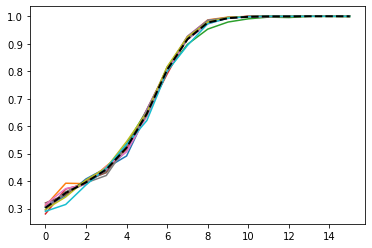

In [8]:
for result in torch.load(f'baselines/results/amc_baseline.pt'):
    plt.plot(result['accs_mod'])
plt.plot(np.mean([result['accs_mod'] for result in torch.load(f'baselines/results/amc_baseline.pt')], axis=0), 'k--', linewidth=2)

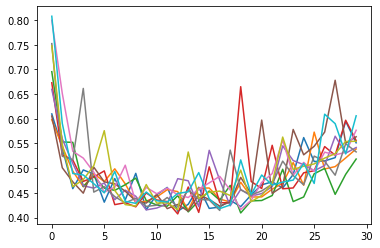

In [9]:
for model_config in torch.load(f'baselines/models/amc_baseline.pt'):
    plt.plot(model_config['val_losses'])

In [105]:
test_loader = gen_loader(num_frames=32, snr=np.arange(-15,16,2), batch_size=32, case=0)

y_test = np.zeros(len(test_loader)*32,)
y_hats = np.zeros(len(test_loader)*32,)

for i, (x,y,z) in enumerate(test_loader):
    y_hats[32*i:32*(i+1)] = model(x).argmax(axis=1).detach().cpu()
    y_test[32*i:32*(i+1)] = y.detach().cpu()

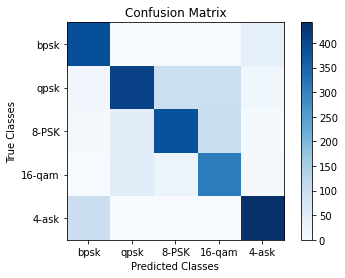

In [106]:
# Import confusion matrix function and use to get our cm
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_hats, y_test) # y_test, and y_hat come from latest test loop above

# Plot the confusion matrix, Blues cmap is probably most popular choice
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1,2,3,4], ['bpsk', 'qpsk', '8-PSK', '16-qam', '4-ask'])
plt.yticks([0,1,2,3,4], ['bpsk', 'qpsk', '8-PSK', '16-qam', '4-ask'])
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.colorbar()

## Add MTL

In [20]:
class amc_model_mtl(nn.Module):
    def __init__(self, case=0):
        super(amc_model_mtl, self).__init__()
            
        # 3 conv layers with a 9 sample wide kernel and padding so that the
        # size of the output remains consistent with the input for each layer
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        # Noise estimator network
        # Case 0 -> estimate linear SNR, no negative values
        if case == 0:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(512,512),
                                        nn.ReLU(),
                                        nn.Linear(512,128),
                                        nn.ReLU(),
                                        nn.Linear(128,64),
                                        nn.ReLU(),
                                        nn.Linear(64,1),
                                        nn.ReLU())
        # Case 1 -> estimate SNR dBs, negative and positive possible
        elif case == 1:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(512,512),
                                        nn.ReLU(),
                                        nn.Linear(512,128),
                                        nn.ReLU(),
                                        nn.Linear(128,64),
                                        nn.ReLU(),
                                        nn.Linear(64,1))
        
        # Case 2 -> 16 SNR levels = 16 classes going into CrossEntropyLoss softmax
        elif case == 2:
            self.noise_estimator = nn.Sequential(
                                        nn.Linear(512,512),
                                        nn.ReLU(),
                                        nn.Linear(512,128),
                                        nn.ReLU(),
                                        nn.Linear(128,64),
                                        nn.ReLU(),
                                        nn.Linear(64,16))
        
        # 128 samples x 16 output filters x 2 channels (I/Q) = 4096
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        
        # Extract features with convolutional layers
        x = self.convolutions(x)
        
        # Flatten so it's compatible with fully connected layers for classification
        x_shared = torch.flatten(x,1)
#         print(x.shape)
        
#         First fully connected layer
        y = F.selu(self.fc1(x_shared))
        
        # Final layer responsible for classifying the 5 modulation schemes
        y = F.selu(self.fc2(y))
        
        y = self.fc3(y)
        
        n = self.noise_estimator(x_shared).squeeze()
        
        return y, n

In [11]:
def train_mtl(model, optimizer, train_loader, val_loader, loss_fns, loss_ratios=(0.5, 0.5),
          num_epochs=5, verbose=False):
    
    loss_fn_amc = loss_fns[0]
    loss_fn_snr = loss_fns[1]
    
    losses, val_losses = [], []
    
    losses_mod, val_losses_mod = [], []
    losses_snr, val_losses_snr = [], []
    
    best_loss = np.inf
    
    for epoch in range(num_epochs):
        running_loss = 0
        running_mod_loss, running_snr_loss = 0, 0
        
        for x, y, z in train_loader:
            optimizer.zero_grad()
            
            y_hat, z_hat = model(x)
            
            loss_1 = loss_fn_amc(y_hat, y)
            loss_2 = loss_fn_snr(z_hat, z)
            loss = loss_1*loss_ratios[0] + loss_2*loss_ratios[1]
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            running_mod_loss += loss_1.item()
            running_snr_loss += loss_2.item()
            
        losses.append(running_loss/len(train_loader))
        losses_mod.append(running_mod_loss/len(train_loader))
        losses_snr.append(running_snr_loss/len(train_loader))
        
        with torch.no_grad():
            running_val_loss = 0
            running_snr_val_loss = 0
            for x, y, z in val_loader:
                y_hat, z_hat = model(x)
                
                val_loss = loss_fn_amc(y_hat, y)
                running_val_loss += val_loss.item()
                
                snr_val_loss = loss_fn_snr(z_hat, z)
                running_snr_val_loss += snr_val_loss.item()
                
            val_losses.append(running_val_loss/len(val_loader))
            val_losses_snr.append(running_snr_val_loss/len(val_loader))
        
        if val_losses[-1] < best_loss:
            print(f'val_losses[-1] = {val_losses[-1]}, best_loss = {best_loss}, model saved at {epoch}')
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
        
        if verbose:
            print(f"Loss: {losses[-1]}, Val loss: {val_losses[-1]}")
            
    model.load_state_dict(saved_model)
    
    return model, losses, losses_mod, losses_snr, val_losses, val_losses_snr

In [12]:
all_loss_ratios = []
for i in range(1,10):
    models = []

    amc_weight = 1
    snr_weight = round(1 - i*0.1, 1)
    
    loss_ratios = (amc_weight, snr_weight)
    
    all_loss_ratios.append(loss_ratios)

In [13]:
all_loss_ratios

[(1, 0.9),
 (1, 0.8),
 (1, 0.7),
 (1, 0.6),
 (1, 0.5),
 (1, 0.4),
 (1, 0.3),
 (1, 0.2),
 (1, 0.1)]

In [14]:
num_epochs = 30

loss_fns = (nn.CrossEntropyLoss(), nn.MSELoss())

In [15]:
num_iter = 5

for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    
    models = []
    for j in range(num_iter):
        print(f"iter {j}")
        dataset = torch.load(f"data/amc_data_512_case_0.pt")
        train_loader = dataset['train_loader']
        val_loader = dataset['val_loader']
        
        torch.manual_seed(j)
        model_mtl = amc_model_mtl()
        model_mtl.cuda()

        optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.0005, weight_decay=0.0001)

        model, losses, losses_mod, losses_snr, val_losses, val_losses_snr = train_mtl(model_mtl, optimizer, train_loader, 
                                                                                      val_loader, loss_fns, 
                                                                                      num_epochs=num_epochs, verbose=False, 
                                                                                      loss_ratios=loss_ratios)
        
        model_config = {"weights": model_mtl.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses,
                        "losses_mod": losses_mod,
                        "losses_snr": losses_snr,
                        "val_losses_snr": val_losses_snr}
        
        models.append(model_config)
    torch.save(models, f'models/case_0/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(1, 0.9)
iter 0
val_losses[-1] = 1.5908802591264248, best_loss = inf, model saved at 0
val_losses[-1] = 1.5583900667726993, best_loss = 1.5908802591264248, model saved at 1
val_losses[-1] = 1.4907583482563496, best_loss = 1.5583900667726993, model saved at 2
val_losses[-1] = 1.4068447828292847, best_loss = 1.4907583482563496, model saved at 3
val_losses[-1] = 1.0421560928225517, best_loss = 1.4068447828292847, model saved at 4
val_losses[-1] = 0.8252004489302636, best_loss = 1.0421560928225517, model saved at 5
val_losses[-1] = 0.7392387162894011, best_loss = 0.8252004489302636, model saved at 6
val_losses[-1] = 0.6731798125430941, best_loss = 0.7392387162894011, model saved at 7
val_losses[-1] = 0.6107279766350985, best_loss = 0.6731798125430941, model saved at 10
val_losses[-1] = 0.595141552016139, best_loss = 0.6107279766350985, model saved at 18
val_losses[-1] = 0.5842453259974718, best_loss = 0.595141552016139, model saved at 20
val_losses[-1] = 0.5759552739560604, best_loss = 0.5

In [16]:
def test_model_mtl(model, snr_range, num_frames=128, samples_per_frame=1024):
    accs = []
    snr_errs = []

    model.eval().cpu()

    with torch.no_grad():
        for snr in snr_range:

            bpsk_data, _ = gen_tensor_data('BPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qpsk_data, _ = gen_tensor_data('QPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            psk_data, _ = gen_tensor_data('8-PSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qam_data, _ = gen_tensor_data('16-QAM', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            ask_data, _ = gen_tensor_data('4-ASK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)

            test_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))

            bpsk_labels = torch.zeros(bpsk_data.shape[0])
            qpsk_labels = torch.ones(qpsk_data.shape[0])
            psk_labels = torch.ones(qam_data.shape[0])*2
            qam_labels = torch.ones(qam_data.shape[0])*3
            ask_labels = torch.ones(ask_data.shape[0])*4

            test_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels))

            y_hat, snr_hat = model(test_data)
            
            results = torch.argmax(y_hat, axis=1)
            
            accs.append(torch.sum(results == test_labels).float() / test_data.shape[0])
            
    return accs

In [17]:
snr_range = np.arange(-15,16,2)

# for models in sorted(os.listdir('models')):
for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    results = []
    for model in torch.load(f'models/case_0/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt'):
        model_mtl = amc_model_mtl()
        model_mtl.load_state_dict(model['weights'])
        accs_mod = test_model_mtl(model_mtl, snr_range, num_frames=128)
        
        result = {"accs_mod": accs_mod,
                   "snr_range": snr_range,
                   "model": model}
        results.append(result)
    torch.save(results, f'results/case_0/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(1, 0.9)
(1, 0.8)
(1, 0.7)
(1, 0.6)
(1, 0.5)
(1, 0.4)
(1, 0.3)
(1, 0.2)
(1, 0.1)


## Add MTL, case 1

In [18]:
train_snr = np.arange(-15,16,2)

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32, case=1)
val_loader = gen_loader(num_frames=64, snr=train_snr, batch_size=32, case=1)

dataset = {'train_loader': train_loader,
           'val_loader': val_loader}

torch.save(dataset, f"data/amc_data_512_case_1.pt")

In [22]:
num_epochs = 30
num_iter = 5

loss_fns = (nn.CrossEntropyLoss(), nn.MSELoss())

for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    
    models = []
    for j in range(num_iter):
        print(f"iter {j}")
        dataset = torch.load(f"data/amc_data_512_case_1.pt")
        train_loader = dataset['train_loader']
        val_loader = dataset['val_loader']
        
        torch.manual_seed(j)
        model_mtl = amc_model_mtl(case=1)
        model_mtl.cuda()

        optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.0005, weight_decay=0.0001)

        model, losses, losses_mod, losses_snr, val_losses, val_losses_snr = train_mtl(model_mtl, optimizer, train_loader, 
                                                                                      val_loader, loss_fns, 
                                                                                      num_epochs=num_epochs, verbose=False, 
                                                                                      loss_ratios=loss_ratios)
        
        model_config = {"weights": model_mtl.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses,
                        "losses_mod": losses_mod,
                        "losses_snr": losses_snr,
                        "val_losses_snr": val_losses_snr}
        
        models.append(model_config)
    torch.save(models, f'models/case_1/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(1, 0.9)
iter 0
val_losses[-1] = 1.441458959132433, best_loss = inf, model saved at 0
val_losses[-1] = 0.971820030361414, best_loss = 1.441458959132433, model saved at 1
val_losses[-1] = 0.7484014149755239, best_loss = 0.971820030361414, model saved at 2
val_losses[-1] = 0.7161662861704826, best_loss = 0.7484014149755239, model saved at 3
val_losses[-1] = 0.6407490365207196, best_loss = 0.7161662861704826, model saved at 4
val_losses[-1] = 0.6119059583172202, best_loss = 0.6407490365207196, model saved at 5
val_losses[-1] = 0.5840258114039898, best_loss = 0.6119059583172202, model saved at 6
val_losses[-1] = 0.574721753038466, best_loss = 0.5840258114039898, model saved at 7
val_losses[-1] = 0.527362172678113, best_loss = 0.574721753038466, model saved at 9
val_losses[-1] = 0.5004938848316669, best_loss = 0.527362172678113, model saved at 10
val_losses[-1] = 0.4578455202281475, best_loss = 0.5004938848316669, model saved at 14
val_losses[-1] = 0.4421844758559018, best_loss = 0.45784552

In [23]:
snr_range = np.arange(-15,16,2)

# for models in sorted(os.listdir('models')):
for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    results = []
    for model in torch.load(f'models/case_1/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt'):
        model_mtl = amc_model_mtl(case=1)
        model_mtl.load_state_dict(model['weights'])
        accs_mod = test_model_mtl(model_mtl, snr_range, num_frames=128)
        
        result = {"accs_mod": accs_mod,
                   "snr_range": snr_range,
                   "model": model}
        results.append(result)
    torch.save(results, f'results/case_1/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(1, 0.9)
(1, 0.8)
(1, 0.7)
(1, 0.6)
(1, 0.5)
(1, 0.4)
(1, 0.3)
(1, 0.2)
(1, 0.1)


## Add MTL, case 2

In [24]:
train_snr = np.arange(-15,16,2)

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32, case=2)
val_loader = gen_loader(num_frames=64, snr=train_snr, batch_size=32, case=2)

dataset = {'train_loader': train_loader,
           'val_loader': val_loader}

torch.save(dataset, f"data/amc_data_512_case_2.pt")

In [25]:
num_epochs = 30
num_iter = 5

loss_fns = (nn.CrossEntropyLoss(), nn.CrossEntropyLoss())

for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    
    models = []
    for j in range(num_iter):
        print(f"iter {j}")
        dataset = torch.load(f"data/amc_data_512_case_2.pt")
        train_loader = dataset['train_loader']
        val_loader = dataset['val_loader']
        
        torch.manual_seed(j)
        model_mtl = amc_model_mtl(case=2)
        model_mtl.cuda()

        optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.0005, weight_decay=0.0001)

        model, losses, losses_mod, losses_snr, val_losses, val_losses_snr = train_mtl(model_mtl, optimizer, train_loader, 
                                                                                      val_loader, loss_fns, 
                                                                                      num_epochs=num_epochs, verbose=False, 
                                                                                      loss_ratios=loss_ratios)
        
        model_config = {"weights": model_mtl.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses,
                        "losses_mod": losses_mod,
                        "losses_snr": losses_snr,
                        "val_losses_snr": val_losses_snr}
        
        models.append(model_config)
    torch.save(models, f'models/case_2/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(1, 0.9)
iter 0
val_losses[-1] = 1.0015151225030423, best_loss = inf, model saved at 0
val_losses[-1] = 0.811079940572381, best_loss = 1.0015151225030423, model saved at 1
val_losses[-1] = 0.6611665023490787, best_loss = 0.811079940572381, model saved at 2
val_losses[-1] = 0.5986242212355137, best_loss = 0.6611665023490787, model saved at 3
val_losses[-1] = 0.5393058797344565, best_loss = 0.5986242212355137, model saved at 4
val_losses[-1] = 0.5179628105834126, best_loss = 0.5393058797344565, model saved at 5
val_losses[-1] = 0.5138407708145678, best_loss = 0.5179628105834126, model saved at 6
val_losses[-1] = 0.49173193480819466, best_loss = 0.5138407708145678, model saved at 7
val_losses[-1] = 0.47604854963719845, best_loss = 0.49173193480819466, model saved at 9
val_losses[-1] = 0.465094197448343, best_loss = 0.47604854963719845, model saved at 11
val_losses[-1] = 0.4457358210347593, best_loss = 0.465094197448343, model saved at 12
val_losses[-1] = 0.4426851633936167, best_loss = 0.

In [26]:
snr_range = np.arange(-15,16,2)

# for models in sorted(os.listdir('models')):
for loss_ratios in all_loss_ratios:
    print(loss_ratios)
    results = []
    for model in torch.load(f'models/case_2/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt'):
        model_mtl = amc_model_mtl(case=2)
        model_mtl.load_state_dict(model['weights'])
        accs_mod = test_model_mtl(model_mtl, snr_range, num_frames=128)
        
        result = {"accs_mod": accs_mod,
                   "snr_range": snr_range,
                   "model": model}
        results.append(result)
    torch.save(results, f'results/case_2/amc_{loss_ratios[0]}_{loss_ratios[1]}.pt')

(1, 0.9)
(1, 0.8)
(1, 0.7)
(1, 0.6)
(1, 0.5)
(1, 0.4)
(1, 0.3)
(1, 0.2)
(1, 0.1)
